In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import uuid

In [3]:
# 日线数据 - 用于生成交易信号
df_daily = pd.read_csv('BTC_USDT_1day_2021.1.1-2021.12.31一年数据.csv')

# 分钟线数据 - 用于精确判断卖出
df_minute = pd.read_csv('BTC_USDT_30min_2021.1.1-2021.12.31一年数据.csv')

# 给分钟数据添加日期列（用于分组）
df_minute['date'] = pd.to_datetime(df_minute['datatime'], unit='ms').dt.date
df_daily['date'] = pd.to_datetime(df_daily['datatime'], unit='ms').dt.date

In [8]:
df_minute.head()

,Unnamed: 0,datatime,open,high,low,close,volume,date
0,0,1609459200000,28923.63,29017.50,28690.17,28836.63,1320.688748,2021-01-01
1,1,1609461000000,28836.63,29031.34,28836.62,28995.13,991.122697,2021-01-01
2,2,1609462800000,28995.13,29417.87,28960.35,29385.39,3449.118444,2021-01-01
3,3,1609464600000,29387.07,29470.00,29311.75,29409.99,1953.950027,2021-01-01
4,4,1609466400000,29410.00,29465.26,29201.78,29298.86,1244.624776,2021-01-01


In [9]:
import talib

# 使用talib计算RSI（默认周期为14）
df_minute['rsi'] = talib.RSI(df_minute['close'], timeperiod=14)

# 查看结果
df_minute.head(20)  # 前14行的RSI会是NaN，因为需要14个周期的数据

,Unnamed: 0,datatime,open,high,low,close,volume,date,rsi
0,0,1609459200000,28923.63,29017.50,28690.17,28836.63,1320.688748,2021-01-01,NaN
1,1,1609461000000,28836.63,29031.34,28836.62,28995.13,991.122697,2021-01-01,NaN
2,2,1609462800000,28995.13,29417.87,28960.35,29385.39,3449.118444,2021-01-01,NaN
3,3,1609464600000,29387.07,29470.00,29311.75,29409.99,1953.950027,2021-01-01,NaN
4,4,1609466400000,29410.00,29465.26,29201.78,29298.86,1244.624776,2021-01-01,NaN
5,5,1609468200000,29298.87,29341.21,29120.03,29194.65,1139.606784,2021-01-01,NaN
6,6,1609470000000,29195.25,29311.00,29150.02,29215.84,692.388143,2021-01-01,NaN
7,7,1609471800000,29216.03,29367.00,29190.83,29278.40,768.956934,2021-01-01,NaN
8,8,1609473600000,29278.41,29395.00,29278.40,29332.81,871.915339,2021-01-01,NaN
9,9,1609475400000,29332.81,29373.60,29029.40,29220.31,1166.131464,2021-01-01,NaN


回测

In [59]:
ori_capital = 100000.0 # 初始金额
capital = ori_capital # 当前可用资金

in_ratio = 0.03 # 投资比例 
commission_rate = 0.001  # 手续费率

stop_loss_rate = 0.5 # 止损率
stop_make_rate = 0.5 # 止盈率

all_trades = [] # 用于存储所有交易记录的列表

k1 = 0.48

In [ ]:


for i in range(len(df_daily)):

    # 跳过前n个周期
    if i < 14:
        continue

    # 获取数据
    data_today = df_daily.iloc[i] # 今天日线
    data_prev = df_daily.iloc[i-1] # 昨天日线
    today_date = data_today['date'] # 当天日期

    # 判断昨天涨跌
    ''' 
    昨天涨 = True
    昨天跌 = False
    '''
    prev_up = data_prev['close'] > data_prev['open']


    ''' 根据波动率构造交易规则
    (p[t] - p_open[t])/p_open[t] = k1 * pre_range
    pre_range = (p_high[t-1] - p_low[t-1])/p_open[t-1]

    p[t] = k1 * pre_range * p_open[t] + p_open[t]
    p[t] = p_open[t] * (1 + k1 * pre_range)

    
    ''' 
    # 昨天的波动率
    pre_range = (data_prev['high'] - data_prev['low']) / data_prev['open']

    if prev_up: # 如果昨天涨 那今天做空
        predict_price = data_today['open'] * (1 - k1 * pre_range)
        if predict_price < data_today['open']: # 可以做空
            direction = -1 # 做空

    else: # 如果昨天跌 那今天做多
        predict_price = data_today['open'] * (1 + k1 * pre_range)
        if predict_price > data_today['open']: # 可以做多
            direction = 1 # 做多

            # 买入
            in_price = data_today['open'] # 买入价格
            in_money = capital * in_ratio # 购买金额
            buy_commission = in_money * commission_rate # 买入手续费
            buy_amount = (in_money - buy_commission)/in_price # 购买数量

            capital = capital - in_money # 余额变化

            in_time = data_today['datatime']
            in_time_readable = datetime.fromtimestamp(in_time/ 1000) # 买入时间

            # 计算止盈止损
            # 做空止盈止损
            if direction == -1:
                stop_loss_price = in_price * (1 + stop_loss_rate)
                stop_make_price = in_price * (1 - stop_make_rate)
            # 做多止盈止损
            elif direction == 1:
                stop_loss_price = in_price * (1 - stop_loss_rate)
                stop_make_price = in_price * (1 + stop_make_rate)
            
            # 扫描分钟数据
            today_minutes = df_minute[df_minute['date'] == today_date].copy()
            out_price = None
            out_time = None

            for idx,minute_data in today_minutes.iterrows():

                # 止盈：最高价触及止盈价或预测价
                if minute_data['high'] >= min(predict_price,stop_make_price):
                    out_price = min(predict_price,stop_make_price)
                    out_time = minute_data['datatime']
                    break
                
                # 止损：最低价触及止损价
                elif minute_data['low'] <= stop_loss_price:
                    out_price = stop_loss_price
                    out_time = minute_data['datatime']
                    break

            # 日内平仓
            # 未触发则 用当天最后一根k线收盘价平仓
            if out_price is None:
                out_price = today_minutes.iloc[-1]['close']
                out_time = today_minutes.iloc[-1]['datatime']
            out_time_readable = datetime.fromtimestamp(out_time / 1000) # 平仓时间
            
            # 卖出
            sell_money = out_price * buy_amount # 卖出金额
            sell_commission = sell_money * commission_rate # 卖出手续费
            out_money = sell_money - sell_commission # 最终卖出金额

            capital = capital + out_money # 余额变化

            # 计算本次交易信息
            trade = {
                'uuid': str(uuid.uuid4()),  # 交易ID
                'symbol': 'BTC_USDT',  # 交易品种
                
                'in_price': in_price,  # 买入价格
                'out_price': out_price,  # 卖出价格
                
                'stop_loss_price': stop_loss_price,  # 止损价格
                'stop_make_price': stop_make_price,  # 止盈价格
                
                'commission_rate': commission_rate,  # 手续费率
                'commission': 0.0,  # 固定手续费
                
                'profit': out_money-in_money,  # 这笔交易最终盈利
                
                'quantity': buy_amount,  # 交易仓位 交易数量
                
                'in_time': in_time_readable,  # 买入时间
                'out_time': out_time_readable,  # 卖出时间
                
                'direction': direction,  # 交易方向 1=做多 -1=做空

                # 将上一周期的rsi添加到回测结果中
                'rsi': df_minute.loc[idx - 1, 'rsi'] if idx > 0 else None,
                
            }

            # 记录本次交易信息
            all_trades.append(trade)


# 将交易记录转换为DataFrame
trades_df = pd.DataFrame(all_trades)

In [61]:
trades_df.head()

,uuid,symbol,in_price,out_price,stop_loss_price,stop_make_price,commission_rate,commission,profit,quantity,in_time,out_time,direction,rsi
0,71155460-e2e5-449e-8997-3ffe3faa63ba,BTC_USDT,36737.43,35994.980000,18368.715,55106.145,0.001,0.0,-66.504704,0.081579,2021-01-16 08:00:00,2021-01-17 07:30:00,1,42.002972
1,bf71e434-3841-4fbe-99fd-5789e91a6abb,BTC_USDT,35994.98,35828.610000,17997.490,53992.470,0.001,0.0,-19.822190,0.083206,2021-01-17 08:00:00,2021-01-18 07:30:00,1,58.300768
2,df0a9681-b9ff-4f2e-a849-174a9ef4366e,BTC_USDT,35824.99,37259.383785,17912.495,53737.485,0.001,0.0,113.781327,0.083584,2021-01-18 08:00:00,2021-01-18 20:00:00,1,58.620948
3,2f3a3b73-3c01-4bfe-a737-488ec5a02856,BTC_USDT,35901.94,35468.230000,17950.970,53852.910,0.001,0.0,-42.177347,0.083500,2021-01-20 08:00:00,2021-01-21 07:30:00,1,60.525867
4,f960135a-cfa4-4123-9dff-d53d656a4984,BTC_USDT,35468.23,30850.130000,17734.115,53202.345,0.001,0.0,-395.769432,0.084486,2021-01-21 08:00:00,2021-01-22 07:30:00,1,39.884314


In [62]:
# 查看RSI>55的交易数量
rsi_above_55 = trades_df[trades_df['rsi'] > 55]

print(f"总交易笔数：{len(trades_df)}")
print(f"RSI > 55 的交易笔数：{len(rsi_above_55)}")
print(f"占比：{len(rsi_above_55)/len(trades_df)*100:.2f}%")

总交易笔数：175
RSI > 55 的交易笔数：89
占比：50.86%


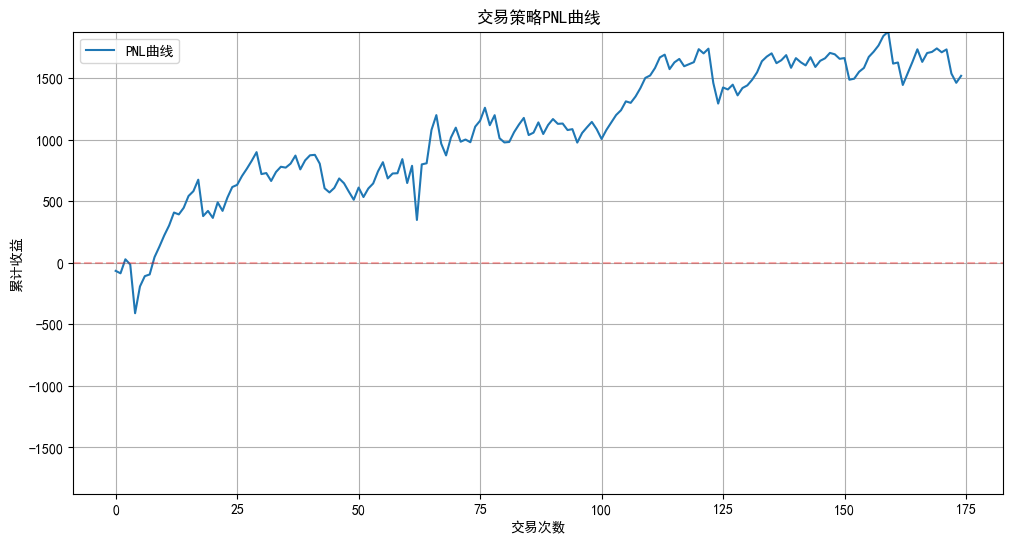

In [63]:
# pnl曲线

import pandas as pd
import matplotlib.pyplot as plt

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 计算累计收益
pnl = trades_df['profit'].cumsum()

# 获取y轴的最大绝对值，用于设置对称的y轴范围
y_max = max(abs(pnl.max()), abs(pnl.min()))

# 绘制PNL曲线
plt.figure(figsize=(12, 6))
plt.plot(pnl, label='PNL曲线')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)  # 添加y=0的参考线
plt.title('交易策略PNL曲线')
plt.xlabel('交易次数')
plt.ylabel('累计收益')
plt.grid(True)
plt.legend()

# 设置y轴范围，使0为中心
plt.ylim(-y_max, y_max)

plt.show()

In [ ]:
''' 
如果遍历k值都亏钱
就需要再次叠加indicator

时间序列 -> 处理成平稳的时间序列
mean均值 var方差 是一个常数
处理方法 除以 波动率

'''

In [ ]:
''' 
rsi 强弱相对指数
rsi包含当前周期的收盘价
需要将上一周期的rsi作为参考

'''

原始策略总盈亏：1517.11
有RSI记录的交易总盈亏：1517.11
差异：0.00

原始交易笔数：175
有RSI记录的交易笔数：175
丢失的交易笔数：0


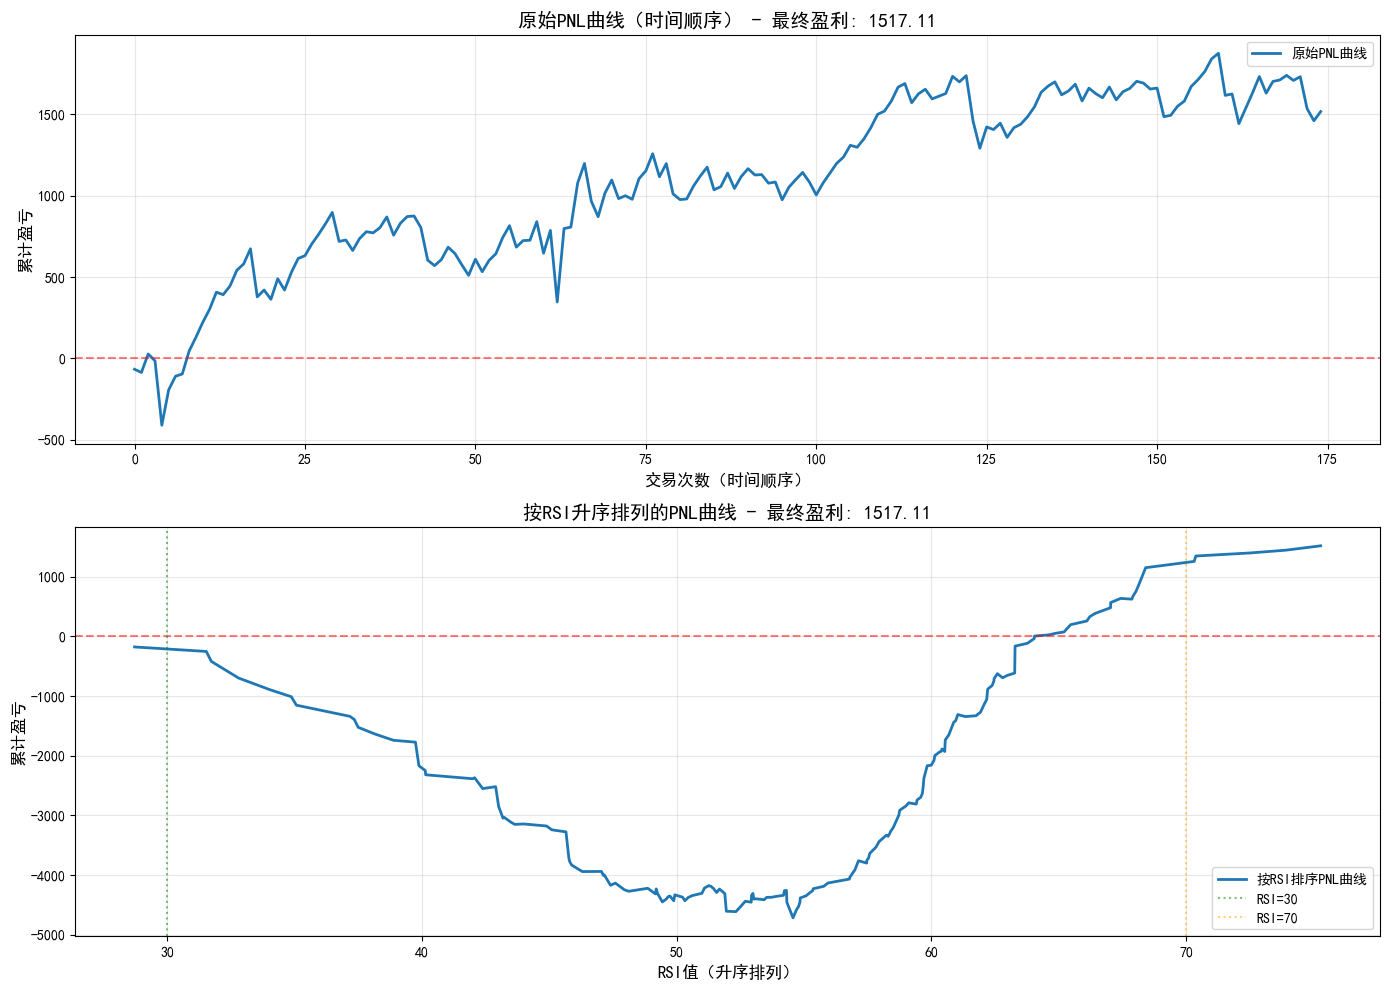

In [64]:
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 原始PNL（按时间顺序）
trades_df['cumulative_pnl_time'] = trades_df['profit'].cumsum()

# 过滤掉RSI为NaN的交易
trades_with_rsi = trades_df[trades_df['rsi'].notna()].copy()

# 按RSI排序的PNL
trades_sorted = trades_with_rsi.sort_values('rsi').reset_index(drop=True)
trades_sorted['cumulative_pnl_rsi'] = trades_sorted['profit'].cumsum()

# 对比两个最终值
print(f"原始策略总盈亏：{trades_df['profit'].sum():.2f}")
print(f"有RSI记录的交易总盈亏：{trades_with_rsi['profit'].sum():.2f}")
print(f"差异：{trades_df['profit'].sum() - trades_with_rsi['profit'].sum():.2f}")
print(f"\n原始交易笔数：{len(trades_df)}")
print(f"有RSI记录的交易笔数：{len(trades_with_rsi)}")
print(f"丢失的交易笔数：{len(trades_df) - len(trades_with_rsi)}")

# 绘制对比图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 上图：原始PNL（按时间）
ax1.plot(trades_df['cumulative_pnl_time'], linewidth=2, label='原始PNL曲线')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('交易次数（时间顺序）', fontsize=12)
ax1.set_ylabel('累计盈亏', fontsize=12)
ax1.set_title(f'原始PNL曲线（时间顺序） - 最终盈利: {trades_df["profit"].sum():.2f}', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 下图：按RSI排序的PNL
ax2.plot(trades_sorted['rsi'], trades_sorted['cumulative_pnl_rsi'], linewidth=2, label='按RSI排序PNL曲线')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.axvline(x=30, color='green', linestyle=':', alpha=0.5, label='RSI=30')
ax2.axvline(x=70, color='orange', linestyle=':', alpha=0.5, label='RSI=70')
ax2.set_xlabel('RSI值（升序排列）', fontsize=12)
ax2.set_ylabel('累计盈亏', fontsize=12)
ax2.set_title(f'按RSI升序排列的PNL曲线 - 最终盈利: {trades_with_rsi["profit"].sum():.2f}', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
''' 
可以看出 rsi大于55左右的交易都是盈利
那么可以额外增加一个限制条件
rsi>55
这个rsi是上一个周期的rsi 
因为rsi默认包含本周期收盘价格信息 实际上是拿不到本周期收盘价格信息的

'''

In [ ]:

''' 
区分
1被迫平仓 止损 止盈
2主动平仓 才会考虑信号问题
3被迫平仓 到时间了

区分
日内 级别数据扫描
分钟 级别数据扫描


'''
